<a href="https://colab.research.google.com/github/thekammilian/best-ball-data-bowl/blob/master/Clustering_Positions_into_Prototypes_to_Optimize_Drafting_in_Fantasy_Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Positions into Prototypes to Optimize Drafting in Fantasy Football**

## Participants: Pranav Kammili and Srikar Lanka (Team Boye Mafe)

Pranav Kammili
*   Twitter: @thekammilian
*   LinkedIn: https://www.linkedin.com/in/pranav-kammili-50a4551a9/

Srikar Lanka
*   LinkedIn: https://www.linkedin.com/in/srikar-lanka/


## **Introduction**

When drafting fantasy football teams, there are many approaches with unique priortizations of pick selections. Currently, the NFL features more role versatility than ever before, prompting discussion about whether specific player prototypes contribute to Best Ball success. With this interest, we sought out to determine where high value draft opportunities exist.

For each position, we have clustered commonly-drafted players using **KMeans** clustering. Our statistical data for each player is taken from **nfl_data_py**. For our factors, we source advanced Next Gen Stats (NGS) metrics, weekly/seasonal NFL data, snap counts for clustering and later marge this data with the corresponding Best Ball scoring to determine the optimal clusters.

After this, we analyze four value metrics and ultimately determine ideal cluster types to consider drafting.



**Importing Libraries & generating nfl_data_py seasonal data**

In [ ]:
!pip install nfl_data_py
import pandas as pd
import numpy as np
import os as os

import warnings
import scipy
warnings.filterwarnings("ignore")
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import plotnine
from plotnine import *

In [ ]:
season22 = nfl.import_seasonal_data(years=range(2022,2023))
week = nfl.import_weekly_data(range(2022,2023))

dct = pd.Series(week.player_name.values,index=week.player_id).to_dict();
dct2 = pd.Series(week.position.values,index=week.player_id).to_dict();
dct3 = pd.Series(week.player_display_name.values, index=week.player_id).to_dict();
dct4 = pd.Series(week.recent_team.values, index=week.player_id).to_dict();

season22['player_name'] = season22['player_id'].map(dct)
season22['position'] = season22['player_id'].map(dct2)
season22['player_display_name'] = season22['player_id'].map(dct3)
season22['recent_team'] = season22['player_id'].map(dct4)

Downcasting floats.


**Creating helper functions needed in dataset generation**

In [ ]:
#helper function used for exponential scoring method (0 = did not make playoffs/lost round 1, 1 = lost round 2, 2= lost round 3, 4 = Championship Winner)
def calculate_round_points(playoff_rounds):
    if playoff_rounds == 0 or playoff_rounds == 1 or playoff_rounds == 2:
        return playoff_rounds
    else:
        return 4

In [ ]:
#importing 2022 seasonal data for nfl_py + mapping player_name/position/team data with weekly data
season22 = nfl.import_seasonal_data(years=range(2022,2023))
week = nfl.import_weekly_data(range(2022,2023))

dct = pd.Series(week.player_name.values,index=week.player_id).to_dict();
dct2 = pd.Series(week.position.values,index=week.player_id).to_dict();
dct3 = pd.Series(week.player_display_name.values, index=week.player_id).to_dict();
dct4 = pd.Series(week.recent_team.values, index=week.player_id).to_dict();

season22['player_name'] = season22['player_id'].map(dct)
season22['position'] = season22['player_id'].map(dct2)
season22['player_display_name'] = season22['player_id'].map(dct3)
season22['recent_team'] = season22['player_id'].map(dct4)

Downcasting floats.


In [ ]:
#helper function used to remove suffix from names for mapping several dataframes
def remove_suffix(name):

    suffixes = ["Sr.", "Jr.", "III", "IV", "V"]
    for suffix in suffixes:
        if name.endswith(suffix):
            name = name[:-len(suffix) - 1]

    return name

sc22 = nfl.import_snap_counts(range(2022,2023))
sc22['player'] = sc22['player'].map(remove_suffix)
weekly22 = nfl.import_weekly_data(range(2022,2023))

Downcasting floats.


In [ ]:
#helper function to compute weighted_efficiency for RBS, WRS, & TEs
def weighted_efficiency(carries, receptions, snap_percentage, total_snaps):
  touch_points = carries + receptions
  touch_points_w_percent = touch_points * snap_percentage
  efficiency = (touch_points) / total_snaps
  return efficiency


In [ ]:
#stacking all regular season/playoff datasets into a large dataframe for specified position + mode (reg season or playoffs)
def generate_df(position,mode):
    file = list()
    if mode == "reg":
        for files in os.listdir("reg_2022/regular_season"):
            if (".csv" in files):
                new_file_name = "reg_2022/regular_season/" + files
                file.append(new_file_name)
    elif mode == 'playoff':
        for files in os.listdir("reg_2022/post_season/quarterfinals"):
            if (".csv" in files):
                new_file_name = "reg_2022/post_season/quarterfinals/" + files
                file.append(new_file_name)
        for files in os.listdir("reg_2022/post_season/semifinals"):
            if (".csv" in files):
                new_file_name = "reg_2022/post_season/semifinals/" + files
                file.append(new_file_name)
        for files in os.listdir("reg_2022/post_season/finals"):
            if (".csv" in files):
                new_file_name = "reg_2022/post_season/finals/" + files
                file.append(new_file_name)


    big_pos = pd.DataFrame()
    for item in file:
        df = pd.read_csv(item)
        pos = df[df['position_name'] == position]
        if (len(big_pos) == 0):
            big_pos = pos
        else:
            big_pos = pd.concat([big_pos,pos])

    return big_pos

## **Quarterbacks**

In this section, we outline how we generated clusters and applied KMeans using seasonal data. We chose to use KMeans clustering to perform observational analysis and group players based on similar characteristics.

To effectively cluster each position into respective prototypes, we chose a blend of factors that quantify **statistical production, efficiency**, and **existing role**.

We originally used 25+ features for each group alone, but removed redundant features to avoid multicollinearity and non-distingushable averages across clusters.

In [ ]:
#generating reg and playoff dataframes for qbs
big_qb = generate_df("QB","reg")
playoff_qb = generate_df("QB","playoff")

For the RB, WR, and TE prototypes, we included snap count data to quantify the games where each player has played a prominent role, allowing us to determine their efficiency through snap% and offense snaps.

We don’t have to worry about this with QBs since they generally play the whole game. We included the factors “**week”**, **“offense_pct”**, and **“weighted_efficiency”** in order to cluster players by their purposeful weeks, their snap percentage in those weeks, and how efficient they were in the snaps that they played.

In [ ]:
#developing weighted efficiency metric and storing results into dataframe
rbsc22_all = sc22.query("position == 'RB' and game_type == 'REG'")
rbsc22 = rbsc22_all[rbsc22_all['offense_pct'] >= 0.38]
rbsc22['team_offense_snaps'] = rbsc22['offense_snaps'] * (1 / rbsc22['offense_pct'])
rbsc22['team_offense_snaps'] = rbsc22['team_offense_snaps'].fillna(0.0).astype(int)

rbsc22_sm = rbsc22.groupby('player').agg({'week': 'count','offense_snaps':'sum','team_offense_snaps':'sum'}).reset_index()
rbsc22_sm['offense_pct'] = rbsc22_sm['offense_snaps'] / rbsc22_sm['team_offense_snaps']
rbsc22.rename(columns = {'player':'player_display_name'}, inplace = True)
rb22_m38 = weekly22.merge(rbsc22, how = 'inner', on = ['player_display_name', 'week'])

rb22_m38_gb = rb22_m38.groupby('player_display_name').agg({'week': 'count','offense_snaps': 'sum', 'carries':'sum', 'receptions':'sum', 'offense_pct':'mean'}).reset_index()
rb22_m38_gb['weighted_efficiency'] = weighted_efficiency(rb22_m38_gb['carries'],rb22_m38_gb['receptions'],rb22_m38_gb['offense_pct'], total_snaps = rb22_m38_gb['offense_snaps'])
rb22_m38_final = rb22_m38_gb.query("week >= 5").set_index('player_display_name')

In [ ]:
#developing weighted efficiency metric and storing results into dataframe
wrsc22_all = sc22.query("position == 'WR' and game_type == 'REG'")
wrsc22 = wrsc22_all[wrsc22_all['offense_pct'] >= 0.50]
wrsc22['team_offense_snaps'] = wrsc22['offense_snaps'] * (1 / wrsc22['offense_pct'])
wrsc22['team_offense_snaps'] = wrsc22['team_offense_snaps'].fillna(0.0).astype(int)

wrsc22_sm = wrsc22.groupby('player').agg({'week': 'count','offense_snaps':'sum','team_offense_snaps':'sum'}).reset_index()
wrsc22_sm['offense_pct'] = wrsc22_sm['offense_snaps'] / wrsc22_sm['team_offense_snaps']
wrsc22.rename(columns = {'player':'player_display_name'}, inplace = True)
wr22_m38 = weekly22.merge(wrsc22, how = 'inner', on = ['player_display_name', 'week'])
wr22_m38.rename(columns = {'position_x':'position'}, inplace = True)

wr22_m38_gb = wr22_m38.groupby('player_display_name').agg({'week': 'count','offense_snaps': 'sum', 'receptions':'sum', 'carries': 'sum', 'offense_pct':'mean'}).reset_index()
wr22_m38_gb['weighted_efficiency'] = weighted_efficiency(wr22_m38_gb['carries'],wr22_m38_gb['receptions'],wr22_m38_gb['offense_pct'], total_snaps = wr22_m38_gb['offense_snaps'])
wr22_m38_final = wr22_m38_gb.query("week >= 6").set_index('player_display_name')

In [ ]:
#developing weighted efficiency metric and storing results into dataframe
tesc22_all = sc22.query("position == 'TE' and game_type == 'REG'")
tesc22 = tesc22_all[tesc22_all['offense_pct'] >= 0.34]
tesc22['team_offense_snaps'] = tesc22['offense_snaps'] * (1 / tesc22['offense_pct'])
tesc22['team_offense_snaps'] = tesc22['team_offense_snaps'].fillna(0.0).astype(int)

tesc22_sm = tesc22.groupby('player').agg({'week': 'count','offense_snaps':'sum','team_offense_snaps':'sum'}).reset_index()
tesc22_sm['offense_pct'] = tesc22_sm['offense_snaps'] / tesc22_sm['team_offense_snaps']
tesc22.rename(columns = {'player':'player_display_name'}, inplace = True)
te22_m38 = weekly22.merge(tesc22, how = 'inner', on = ['player_display_name', 'week'])
te22_m38.rename(columns = {'position_x':'position'}, inplace = True)

te22_m38_gb = te22_m38.groupby('player_display_name').agg({'week': 'count','offense_snaps': 'sum', 'receptions':'sum', 'carries': 'sum', 'offense_pct':'mean'}).reset_index()
te22_m38_gb['weighted_efficiency'] = weighted_efficiency(te22_m38_gb['carries'],te22_m38_gb['receptions'],te22_m38_gb['offense_pct'], total_snaps = te22_m38_gb['offense_snaps'])
te22_m38_final = te22_m38_gb.query("week >= 6")

In [ ]:
#generating dataframe with seasonal data features depending on which position is selected
def feature(season22,position):
  if (position == "QB"):
    pos22 = season22.query("position == 'QB' and season_type == 'REG' and completions >= 100")
    qb_attr = ['player_id','player_name',
       'position', 'player_display_name', 'recent_team',
       'passing_yards_after_catch', 'passing_first_downs',
       'passing_2pt_conversions', 'pacr', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'wopr_x', 'wopr_y', 'ry_sh', 'rtdfd_sh', 'yptmpa']
    pos22 = pos22[qb_attr]

  elif (position == "RB"):
    pos22 = season22.query("position == 'RB' and season_type == 'REG'")
    pos22['total tds'] = pos22['rushing_tds'] + pos22['receiving_tds']
    rb_factors = ['player_id',
       'total tds','rushing_yards','rushing_first_downs',
       'receiving_yards_after_catch', 'receiving_first_downs',
        'racr', 'target_share', 'air_yards_share','wopr_x',
       'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtdfd_sh', 'dom', 'w8dom', 'ppr_sh', 'player_name',
       'position', 'player_display_name', 'recent_team']
    pos22 = pos22[rb_factors]

  elif (position == "WR"):
    pos22 = season22.query("position == 'WR' and season_type == 'REG' and receiving_first_downs >= 25")
    pos22['total_tds'] = pos22['rushing_tds'] + pos22['receiving_tds']
    wr_factors = ['player_id', 'rushing_yards',
       'total_tds','receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'racr', 'target_share', 'air_yards_share',
       'wopr_x','games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh',
              'rtdfd_sh', 'dom', 'w8dom', 'ppr_sh', 'player_name',
       'position', 'player_display_name', 'recent_team']
    pos22 = pos22[wr_factors]

  elif (position == "TE"):
    pos22 = season22.query("position == 'TE' and season_type == 'REG'")
    pos22['total tds'] = pos22['rushing_tds'] + pos22['receiving_tds']

    te_factors = ['player_id', 'total tds',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'racr', 'target_share', 'air_yards_share',
       'wopr_x','games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh',
        'rtdfd_sh', 'dom', 'w8dom', 'ppr_sh', 'player_name',
       'position', 'player_display_name', 'recent_team']
    pos22 = pos22[te_factors]

  return pos22

In [ ]:
#process of generating clusters for each position including merging + aggregating multiple features (nfl_data_py, ngs_data, snapcount)
def generate_clusters(pos22, season22, position):
  pos22 = pos22.groupby(['draft_id','player_name']).agg({'pick_points':'mean','projection_adp':'mean',
'overall_pick_number':'mean', 'team_pick_number':'mean'})
  pos22 = pos22.reset_index()
  pos22_sm1 = feature(season22, position)

  if (position == "QB"):
    #QB features
    x = nfl.import_ngs_data('passing', range(2022,2023))
    xy = x[x['completions'] >= 100]
    lst = ['avg_time_to_throw',
       'avg_air_yards_differential', 'aggressiveness',
       'passer_rating','completion_percentage_above_expectation']
    clus = 4

  elif (position == "RB"):
    #RB features
    x = nfl.import_ngs_data('rushing', range(2022,2023))
    x['expected_rush_yards_per_attempt'] = x['expected_rush_yards'] / x['rush_attempts']
    xy = x.query("week > 0")
    lst = ['percent_attempts_gte_eight_defenders', 'expected_rush_yards_per_attempt',
       'rush_yards_over_expected_per_att']
    clus = 6

  elif (position == "WR" or position == "TE"):
    #WR/TE features
    xy = nfl.import_ngs_data('receiving', range(2022,2023))
    lst = ['avg_cushion', 'avg_separation','avg_intended_air_yards', 'catch_percentage']
    if (position == "WR"):
      clus = 5
    else:
      clus = 4

  pos_x = xy.groupby(by = 'player_display_name')[lst].agg({'mean'}).reset_index(drop=False)
  pos_x.columns = pos_x.columns.droplevel(1)

  pos_final = pd.merge(pos22_sm1, pos_x, on=['player_display_name']).set_index('player_display_name').drop(['player_id','player_name','position','recent_team'], axis = 1)

  #merging snapcount data for RBS, WRs, & TEs back into giant dataframe
  if (position == "RB"):
    pos_final = pd.merge(pos_final, rb22_m38_final, left_index=True, right_index=True)

  elif (position == "WR"):
    pos_final = pd.merge(pos_final, wr22_m38_final,left_index=True, right_index=True).drop(['offense_snaps','receptions'], axis = 1)

  elif (position == "TE"):
    pos_final = pd.merge(pos_final, te22_m38_final, on=['player_display_name']).set_index('player_display_name').drop(['offense_snaps','receptions'], axis = 1)
    pos_final.query('week >= 8 and receiving_first_downs >= 15', inplace=True)

  #apply KMeans clustering with specified size based on position to group players into prototypes
  pos_final['clusters'] = KMeans(n_clusters = clus).fit_predict(pos_final)

  display(pos_final.groupby('clusters')[pos_final.columns].agg({'mean'}))
  print(pos_final.columns)

  pos_dict = pd.Series(pos_final.clusters.values,index=pos_final.index).to_dict()
  pos22['clusters'] = pos22['player_name'].map(pos_dict)

  return pos22


In [ ]:
#storing final cluster results into big_qb2 dataframe
big_qb2 = generate_clusters(big_qb,season22,"QB")
big_qb2 = big_qb2[big_qb2['clusters'].isna() == False]
#dataframe w/ clusters and averages across different factors shown

,passing_yards_after_catch,passing_first_downs,passing_2pt_conversions,pacr,carries,rushing_yards,rushing_tds,rushing_fumbles_lost,rushing_first_downs,rushing_epa,...,wopr_y,ry_sh,rtdfd_sh,yptmpa,avg_time_to_throw,avg_air_yards_differential,aggressiveness,passer_rating,completion_percentage_above_expectation,clusters
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
clusters,,,,,,,,,,,,,,,,,,,,,
0,1315.266667,130.666667,0.600000,12.292083,37.066667,139.466667,1.466667,0.666667,13.066667,1.084579,...,0.000188,0.000019,0.000000,0.000134,2.764179,-2.144346,15.511395,88.457652,-0.959177,0.0
1,2192.444444,222.444444,1.888889,17.923369,49.222222,186.888889,2.111111,1.222222,16.666667,-1.316311,...,0.001044,0.000020,0.000000,0.000406,2.714553,-2.036779,13.508270,96.528418,0.417419,1.0
2,677.750000,75.500000,0.625000,6.870395,26.625000,98.500000,1.375000,0.250000,7.875000,0.022180,...,0.001392,-0.001357,0.002907,-0.007506,2.844064,-2.341382,17.031777,83.758330,-2.161999,2.0
3,1377.200000,145.800000,1.000000,13.987120,136.200000,827.400000,7.600000,0.800000,58.200000,46.243710,...,0.000000,0.000000,0.000000,0.000000,2.929487,-2.170224,12.299340,93.385449,-0.800738,3.0


Index(['passing_yards_after_catch', 'passing_first_downs',
       'passing_2pt_conversions', 'pacr', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles_lost', 'rushing_first_downs',
       'rushing_epa', 'rushing_2pt_conversions', 'wopr_x', 'wopr_y', 'ry_sh',
       'rtdfd_sh', 'yptmpa', 'avg_time_to_throw', 'avg_air_yards_differential',
       'aggressiveness', 'passer_rating',
       'completion_percentage_above_expectation', 'clusters'],
      dtype='object')


**Cluster definitions for quarterbacks**

**Cluster 0**: High-risk and low-reward. These players have high injury rates, play on unsuccessful teams, and are below-average by most advanced metrics.

Ex: Baker Mayfield, Matt Ryan

**Cluster 1**: Pass-first quarterbacks. Some have mobility but most will throw the ball down the field when given the opportunity.

Ex: Geno Smith, Patrick Mahomes

**Cluster 2**: Backup quarterbacks. These players have lower passer ratings, higher aggressiveness, lower completion percentage above expectation. Very limited sample size due to small role.

Ex: Zach Wilson, Marcus Mariota

**Cluster 3**: Scramblers. Higher rushing yards/carries, low passing aggressiveness, longest time to throw.

Ex: Lamar Jackson, Justin Fields



**Reference cell 3 cells below to see full clusters.**

In [ ]:
#generating dictionaries to map player_name to clusters & draft_id to tournamnet_entry_id (playoff & reg merging)
qb_clus_dct = pd.Series(big_qb2.clusters.values,index=big_qb2.player_name).to_dict()
entry_dict = pd.Series(big_qb.tournament_entry_id.values, index=big_qb.draft_id).to_dict()

In [ ]:
#mapping tournament entry using draft_id for playoff_data
big_qb2['tournament_entry_id'] = big_qb2['draft_id'].map(entry_dict)

In [ ]:
sorted(qb_clus_dct.items(), key=lambda x: x[1])

[('Baker Mayfield', 0.0),
 ('Dak Prescott', 0.0),
 ('Davis Mills', 0.0),
 ('Derek Carr', 0.0),
 ('Kyler Murray', 0.0),
 ('Mac Jones', 0.0),
 ('Matt Ryan', 0.0),
 ('Matthew Stafford', 0.0),
 ('Russell Wilson', 0.0),
 ('Ryan Tannehill', 0.0),
 ('Tua Tagovailoa', 0.0),
 ('Jimmy Garoppolo', 0.0),
 ('Kenny Pickett', 0.0),
 ('Jacoby Brissett', 0.0),
 ('Andy Dalton', 0.0),
 ('Aaron Rodgers', 1.0),
 ('Jared Goff', 1.0),
 ('Joe Burrow', 1.0),
 ('Justin Herbert', 1.0),
 ('Kirk Cousins', 1.0),
 ('Patrick Mahomes', 1.0),
 ('Tom Brady', 1.0),
 ('Trevor Lawrence', 1.0),
 ('Geno Smith', 1.0),
 ('Carson Wentz', 2.0),
 ('Zach Wilson', 2.0),
 ('Marcus Mariota', 2.0),
 ('Joe Flacco', 2.0),
 ('Taylor Heinicke', 2.0),
 ('Mike White', 2.0),
 ('Daniel Jones', 3.0),
 ('Jalen Hurts', 3.0),
 ('Josh Allen', 3.0),
 ('Justin Fields', 3.0),
 ('Lamar Jackson', 3.0)]

## **Analyze Clusters & Generate Optimal Selections**
After developing clusters, we analyzed performance and assessed how we can optimally select players through performance metrics. The process is broken down into the following steps:

**1)** Random sampling- We took a random sample of 1000 drafts and for each of them, compute metrics for all players. Due to unique scoring across drafts, we decided to compute these metrics for each draft individually to avoid potential skewness.

The two metrics we generate: \
a) 'ev'- the percentile difference between where a player finished and where they were drafted relative to position \
b) 'diff'- the difference between where a player was picked and their adp \

**2)** Integrate playoff performance- We used tournament_entry_id to determine playoff advancement rates and assigned exponential scoring for each round a player wins. 0 = no playoffs; 1 = quarterfinals loss; 2 = semifinal losses, 4 = reached championship. We called this metric 'round_points'.

Additionally, 'pick_points' was used as a final metric in assessing performance because it contextualizes some of these results (positive 'ev' or positive 'diff' does not necesarily imply the best player).

**3)** Visualize metrics- To better undestand the intersection of the these four metrics, we performed Principal Component Analysis (PCA) for dimensionality reduction and computed the loading matrix (correlation between original factors and components) to contextualize which group would be the best. PCA allows us to summarize our 4 main metrics into 2 components. The main parameter of interest was 'pick_points' because it is a direct indicator of production.

**4)** Cluster components- We clustered our components and determined the "best" group using our loading matrix.

**5)** Get cluster frequencies- Using our original clusters of players and the "best" PCA group, we see the distribution of player prototypes.

In [ ]:
import random
length = random.sample(list(big_qb2['draft_id'].unique()), 1000)

lsts = list()
specific = big_qb2[big_qb2['draft_id'].isin(length)]

for item in specific['draft_id'].unique():
    temp = big_qb2[big_qb2['draft_id'] == item]
    temp['prod%'] = scipy.stats.percentileofscore(temp['pick_points'],temp['pick_points'])
    temp['pick%'] = 100 - scipy.stats.percentileofscore(temp['overall_pick_number'],temp['overall_pick_number'])
    temp['ev'] = temp['prod%'] - temp['pick%']
    for x in temp['ev']:
        lsts.append(x)

specific['ev'] = lsts
specific['diff'] = specific['overall_pick_number'] - specific['projection_adp']

In [ ]:
qb_rand = playoff_qb[playoff_qb['tournament_entry_id'].isin(specific['tournament_entry_id'])]

In [ ]:
qb_rand['clusters'] = qb_rand['player_name'].map(qb_clus_dct)
qb_randgb = qb_rand.groupby(['tournament_entry_id','player_name']).agg({'overall_pick_number':'count'}).reset_index()
qb_randgb.rename(columns = {'overall_pick_number': 'playoff_rounds'}, inplace = True)
qb_fin = qb_randgb.merge(specific, how = 'outer', on = ['player_name','tournament_entry_id'])
qb_fin.fillna({'playoff_rounds':0},inplace = True)
qb_fin['round_points'] = qb_fin['playoff_rounds'].map(calculate_round_points)

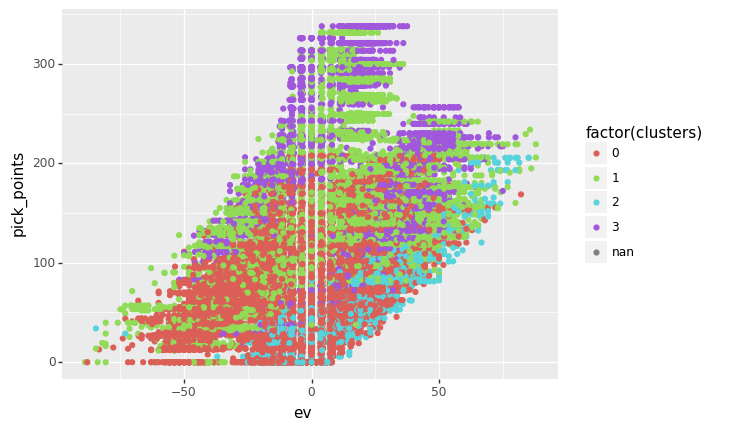

<ggplot: (8793313952004)>

In [ ]:
ggplot(qb_fin) + geom_point(aes(x='ev',y='pick_points',color='factor(clusters)'))

Players in clusters 1 & 3 seem to be performing the best, many of which have positive ev, indicating they are good selections in earlier rounds. Cluster 2 seems to also show relatively positive ev, but could be chosen later due to a lower scoring ceiling.

In [ ]:
qb_fin = qb_fin[qb_fin['clusters'].isna() == False]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ind = qb_fin[['pick_points','diff','ev','round_points']]
clus = qb_fin['clusters'].tolist()
ind2 = StandardScaler().fit_transform(ind)

pca = PCA(n_components=2)
comp = pca.fit_transform(ind2)

prince = pd.DataFrame(data = comp, columns = ['pca1', 'pca2'])
prince['clusters'] = clus

In [ ]:
qb_fin[qb_fin['clusters'] == 1]['player_name'].unique()

array(['Trevor Lawrence', 'Patrick Mahomes', 'Kirk Cousins',
       'Justin Herbert', 'Jared Goff', 'Tom Brady', 'Joe Burrow',
       'Aaron Rodgers', 'Geno Smith'], dtype=object)

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PCA1', 'PCA2'],index=ind.columns)

In [ ]:
loading_matrix

,PCA1,PCA2
pick_points,-0.801283,-0.183253
diff,-0.240867,0.586934
ev,-0.831383,-0.040450
round_points,-0.049436,0.790793


This table tell us that we should look for lower PCA1 values (the more important component because it explains more variance), while PCA2 isn't too significant, except for higher values indicating more playoff success.

In [ ]:
prince['tierings'] = KMeans(n_clusters = 3).fit_predict(prince.iloc[:,:2])

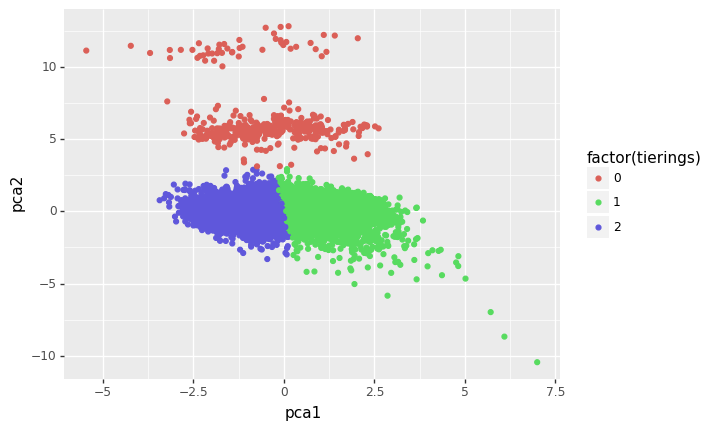

<ggplot: (8792963756472)>

In [ ]:
ggplot(prince) + geom_point(aes(x='pca1', y='pca2',color='factor(tierings)'))

With negative coefficients of pick_points and ev for pca1, group #2 (blue colored cluster) seems to be doing the best on average in the regular season, while group #0 (red colored cluster) has higher playoff advancement rates, being slightly worse in the regular season. This means that blue group quarterbacks should be prioritized first since it affects season performance while quarterbacks in the red tier could be picked later to increase playoff advancement rate.

In [ ]:
data2 = prince[prince['tierings'] == 2]
data2['clusters'].value_counts()

clusters
1.0    4981
3.0    4079
0.0    2729
2.0     751
Name: count, dtype: int64

In [ ]:
data2 = prince[prince['tierings'] == 0]
data2['clusters'].value_counts()

clusters
0.0    135
1.0    121
3.0     93
2.0     25
Name: count, dtype: int64

Clusters 1 (pass-first) and 3 (scramblers) have the best production compared to the other clusters in the regular season and playoffs. However, cluster 0 (high-risk/low-reward) could be a good backup selection if they have elevated roles or better situations in the upcoming season.

# **Runningbacks**
The aformentioned procedure (from QBs) is used for RBs.

In [ ]:
#generating reg and playoff dataframes for rbs
big_rb = generate_df("RB", "reg")
playoff_rb = generate_df("RB", "playoff")

In [ ]:
#storing final cluster results into big_rb2 dataframe
big_rb2 = generate_clusters(big_rb,season22,"RB")
big_rb2 = big_rb2[big_rb2['clusters'].isna() == False]

#dataframe w/ clusters and averages across different factors shown

,total tds,rushing_yards,rushing_first_downs,receiving_yards_after_catch,receiving_first_downs,racr,target_share,air_yards_share,wopr_x,games,...,percent_attempts_gte_eight_defenders,expected_rush_yards_per_attempt,rush_yards_over_expected_per_att,week,offense_snaps,carries,receptions,offense_pct,weighted_efficiency,clusters
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
clusters,,,,,,,,,,,,,,,,,,,,,
0,7.000000,822.375000,43.000000,105.250000,4.375000,-5.517192,0.660447,0.001186,0.991501,14.500000,...,27.395541,4.000872,0.640658,9.000000,295.875000,140.125000,11.125000,0.509681,0.514559,0.0
1,8.666667,988.000000,48.444444,518.666667,21.888889,22.815059,2.363318,-0.080279,3.488781,16.333333,...,21.100939,4.080786,0.433283,15.333333,684.555556,212.777778,63.222222,0.679787,0.404240,1.0
2,3.153846,381.384615,18.076923,139.076923,7.384615,3.782230,0.698639,0.024061,1.064801,10.692308,...,22.575986,4.091140,0.254493,6.461538,217.692308,68.000000,14.384615,0.507960,0.386710,2.0
3,11.800000,1459.400000,70.200000,311.200000,10.200000,-14.309599,1.690294,0.011864,2.543747,16.600000,...,24.533828,3.984870,0.583637,16.400000,727.600000,307.200000,37.600000,0.673455,0.477826,3.0
4,7.363636,917.727273,46.818182,229.363636,10.181818,15.069691,1.282062,0.009947,1.930056,14.909091,...,22.297662,4.132847,0.263814,13.545455,571.636364,198.181818,29.727273,0.653953,0.403958,4.0
5,5.571429,446.285714,22.142857,349.857143,15.857143,-11.475748,1.669745,0.061073,2.547369,15.857143,...,19.976171,3.912160,0.362145,10.714286,374.285714,90.857143,32.857143,0.508758,0.334230,5.0


Index(['total tds', 'rushing_yards', 'rushing_first_downs',
       'receiving_yards_after_catch', 'receiving_first_downs', 'racr',
       'target_share', 'air_yards_share', 'wopr_x', 'games', 'tgt_sh', 'ay_sh',
       'yac_sh', 'wopr_y', 'ry_sh', 'rtdfd_sh', 'dom', 'w8dom', 'ppr_sh',
       'percent_attempts_gte_eight_defenders',
       'expected_rush_yards_per_attempt', 'rush_yards_over_expected_per_att',
       'week', 'offense_snaps', 'carries', 'receptions', 'offense_pct',
       'weighted_efficiency', 'clusters'],
      dtype='object')


**Clusters**:

**Cluster 0**: Inconsistent/injured in run-heavy offenses. Split roles, heavy boxes, highly efficient, low receiving production. The main outlier is Jamaal Williams because he had a productive season but was in a very good run-heavy offense.

Ex: Isiah Pacheco, Brian Robinson

**Cluster 1**: Elite two-way weapons. Very good rushing yards and high receiving yards.

Ex: Austin Ekeler, Joe Mixon

**Cluster 2**: Lightning in a bottle. Worst in most categories and only productive for a month. The main outlier is Breece Hall since he got injured early last year.

Ex: Eno Benjamin, Clyde Edwards-Helaire

**Cluster 3**: Work-horse runningbacks. Highest rushing production and high efficiency.

Ex: Josh Jacobs, Derrick Henry

**Cluster 4**: Moderate/Late bloomers. Good production amongst all factors or they improved as the season went on.

Ex: Kenneth Walker, Ezekiel Elliott

**Cluster 5**: Third-down/not-involved. Played a good number of games but lacked production.

Ex: Rachaad White, Samaje Perine

**Reference cell 3 cells below to see full clusters.**

In [ ]:
#generating dictionaries to map player_name to clusters & draft_id to tournamnet_entry_id (playoff & reg merging)
rb_clus_dct = pd.Series(big_rb2.clusters.values,index=big_rb2.player_name).to_dict()
entry_dict = pd.Series(big_rb.tournament_entry_id.values, index=big_rb.draft_id).to_dict()

In [ ]:
#mapping tournament entry using draft_id for playoff_data
big_rb2['tournament_entry_id'] = big_rb2['draft_id'].map(entry_dict)

In [ ]:
sorted(rb_clus_dct.items(), key=lambda x: x[1])

[('Brian Robinson', 0.0),
 ('Cam Akers', 0.0),
 ('Cordarrelle Patterson', 0.0),
 ('Isiah Pacheco', 0.0),
 ('Jamaal Williams', 0.0),
 ('Khalil Herbert', 0.0),
 ("D'Onta Foreman", 0.0),
 ('Latavius Murray', 0.0),
 ('Aaron Jones', 1.0),
 ('Alvin Kamara', 1.0),
 ('Austin Ekeler', 1.0),
 ('Christian McCaffrey', 1.0),
 ('Dalvin Cook', 1.0),
 ('Joe Mixon', 1.0),
 ('Leonard Fournette', 1.0),
 ('Rhamondre Stevenson', 1.0),
 ('Travis Etienne', 1.0),
 ('Breece Hall', 2.0),
 ('Chase Edmonds', 2.0),
 ('Clyde Edwards-Helaire', 2.0),
 ('Damien Harris', 2.0),
 ('Darrell Henderson', 2.0),
 ('Eno Benjamin', 2.0),
 ('J.K. Dobbins', 2.0),
 ('James Robinson', 2.0),
 ('Kenyan Drake', 2.0),
 ('Melvin Gordon', 2.0),
 ('Jaylen Warren', 2.0),
 ('Chuba Hubbard', 2.0),
 ('Zonovan Knight', 2.0),
 ('Derrick Henry', 3.0),
 ('Josh Jacobs', 3.0),
 ('Miles Sanders', 3.0),
 ('Nick Chubb', 3.0),
 ('Saquon Barkley', 3.0),
 ('Dameon Pierce', 4.0),
 ('David Montgomery', 4.0),
 ('Devin Singletary', 4.0),
 ('Ezekiel Elliott',

## **Analyze Clusters & Generate Optimal Selections**
The aformentioned procedure is followed for RBs

In [ ]:
import random
length = random.sample(list(big_rb2['draft_id'].unique()), 1000)

lsts = list()
specific = big_rb2[big_rb2['draft_id'].isin(length)]

for item in specific['draft_id'].unique():
    temp = big_rb2[big_rb2['draft_id'] == item]
    temp['prod%'] = scipy.stats.percentileofscore(temp['pick_points'],temp['pick_points'])
    temp['pick%'] = 100 - scipy.stats.percentileofscore(temp['overall_pick_number'],temp['overall_pick_number'])
    temp['ev'] = temp['prod%'] - temp['pick%']
    for x in temp['ev']:
        lsts.append(x)

specific['ev'] = lsts
specific['diff'] = specific['overall_pick_number'] - specific['projection_adp']

In [ ]:
#filtering rbs who appear in the random sample of tournament_entry_ids
rb_rand = playoff_rb[playoff_rb['tournament_entry_id'].isin(specific['tournament_entry_id'])]

In [ ]:
#merging tournament_data with the best_ball_data to generate completed dataset
rb_rand['clusters'] = rb_rand['player_name'].map(rb_clus_dct)
rb_randgb = rb_rand.groupby(['tournament_entry_id','player_name']).agg({'overall_pick_number':'count'}).reset_index()
rb_randgb.rename(columns = {'overall_pick_number': 'playoff_rounds'}, inplace = True)
rb_fin = rb_randgb.merge(specific, how = 'outer', on = ['player_name','tournament_entry_id'])
rb_fin.fillna({'playoff_rounds':0},inplace = True)
rb_fin['round_points'] = rb_fin['playoff_rounds'].map(calculate_round_points)

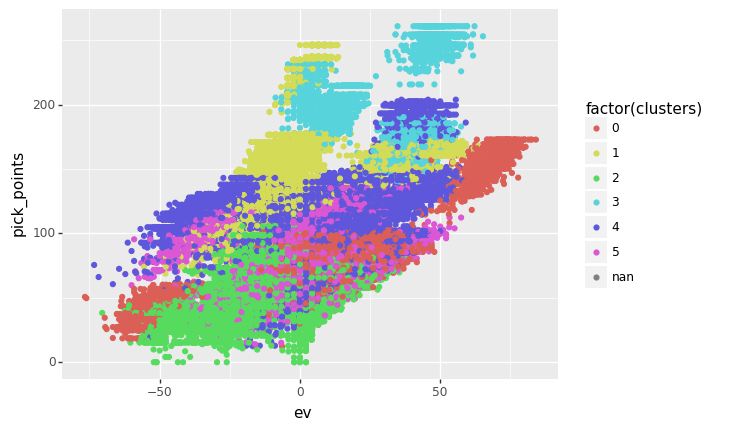

<ggplot: (8793274709146)>

In [ ]:
ggplot(rb_fin) + geom_point(aes(x='ev',y='pick_points',color='factor(clusters)'))

Players in cluster 1 and 3 seem to be performing the best with good ev, indicating they are good early round selections. Clusters 4 and 0 appear to have strong value with almost all points having significantly strong ev, making these set of players good depth picks.

In [ ]:
rb_fin = rb_fin[rb_fin['clusters'].isna() == False]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ind = rb_fin[['pick_points','diff','ev','round_points']]

clus = rb_fin['clusters'].tolist()
ind2 = StandardScaler().fit_transform(ind)

pca = PCA(n_components=2)
comp = pca.fit_transform(ind2)

prince = pd.DataFrame(data = comp, columns = ['pca1', 'pca2'])
prince['clusters'] = clus

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PCA1', 'PCA2'],index=ind.columns)

In [ ]:
loading_matrix

,PCA1,PCA2
pick_points,0.838334,-0.120414
diff,0.166384,0.564283
ev,0.843513,-0.068056
round_points,0.078932,0.816725


This table tell us that we should look for higher PCA1 values (the more important component because it explains more variance), while PCA2 isn't too significant, except for higher values indicating more playoff success.

In [ ]:
prince['tierings'] = KMeans(n_clusters = 3).fit_predict(prince.iloc[:,:2])

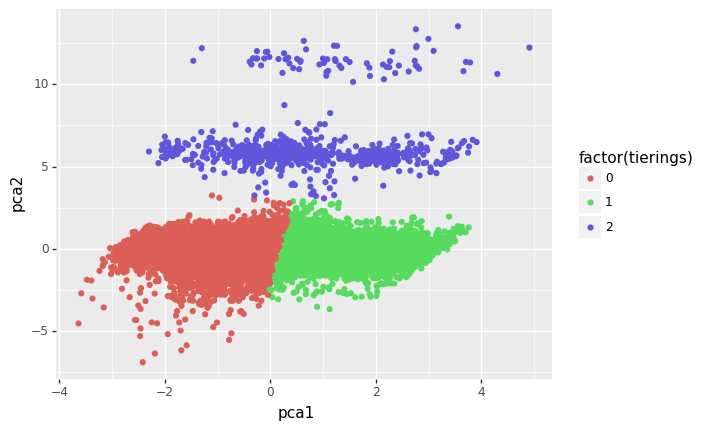

<ggplot: (8792993224686)>

In [ ]:
ggplot(prince) + geom_point(aes(x='pca1', y='pca2',color='factor(tierings)'))

With positive coefficients of pick_points and ev for pca1, group #1 (green color) seems to be doing the best on average in the regular season, while group #2 (blue color) seems to have higher playoff advancement rates, being slightly worse in the regular season. This means that green group runningbacks should be prioritized first since it affects season performance while runningbacks in the blue tier should be picked later to increase playoff advancement rate.


In [ ]:
data2 = prince[prince['tierings'] == 1]
data2['clusters'].value_counts()

clusters
1.0    5874
3.0    4870
4.0    4299
0.0    2291
5.0     882
2.0      71
Name: count, dtype: int64

In [ ]:
data2 = prince[prince['tierings'] == 2]
data2['clusters'].value_counts()

clusters
4.0    164
0.0    131
3.0    128
1.0    126
2.0    125
5.0     83
Name: count, dtype: int64

Elite two-way weapons (cluster 1) and workhorse runningbacks (cluster 3) have the best production in the regular season and playoffs, but the late bloomer/moderate (cluster 4) runningbacks had higher advance rates in the playoffs and were productive during that period. The inconsistent/inefficient tier and lightning in a bottle (clusters 0 and 2 respectively) had high advancement rates  too since they were consistently behind better players, with two-way and workhorse being right there with them.

## **Wide Receivers**

In [ ]:
#generating reg and playoff dataframes for wrs
big_wr = generate_df("WR", "reg")
playoff_wr = generate_df("WR", "playoff")

In [ ]:
#storing final cluster results into big_wr2 dataframe
big_wr2 = generate_clusters(big_wr,season22,"WR")
big_wr2 = big_wr2[big_wr2['clusters'].isna() == False]

,rushing_yards,total_tds,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr_x,games,...,ppr_sh,avg_cushion,avg_separation,avg_intended_air_yards,catch_percentage,week,carries,offense_pct,weighted_efficiency,clusters
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
clusters,,,,,,,,,,,,,,,,,,,,,
0,7.300000,3.700000,141.000000,30.900000,15.914845,11.302583,2.540397,3.770638,6.450042,14.7,...,0.111010,6.152747,2.627011,11.806856,60.786596,13.300000,1.550000,0.779734,0.070546,0.0
1,22.800000,7.800000,513.000000,63.400000,56.598410,17.601592,4.386964,5.352453,10.327162,16.6,...,0.182477,6.059655,3.032827,9.923240,68.158610,16.000000,3.900000,0.847641,0.112572,1.0
2,19.454545,4.545455,251.863636,38.909091,22.799976,14.149842,2.952035,4.071916,7.278393,15.0,...,0.135774,6.268764,2.958135,10.776585,64.873342,14.045455,3.454545,0.819672,0.087429,2.0
3,19.400000,7.100000,390.300000,53.900000,40.323947,15.314553,3.874439,5.119672,9.395429,15.3,...,0.187065,6.030316,2.928465,10.456966,65.554122,14.800000,3.900000,0.883784,0.102330,3.0
4,232.000000,5.000000,493.000000,25.000000,8.942732,23.478538,3.112262,1.712560,5.867184,13.0,...,0.149304,6.587423,3.591032,4.651359,59.445130,12.000000,38.000000,0.785000,0.142405,4.0


Index(['rushing_yards', 'total_tds', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'racr', 'target_share',
       'air_yards_share', 'wopr_x', 'games', 'tgt_sh', 'ay_sh', 'yac_sh',
       'wopr_y', 'ry_sh', 'rtdfd_sh', 'dom', 'w8dom', 'ppr_sh', 'avg_cushion',
       'avg_separation', 'avg_intended_air_yards', 'catch_percentage', 'week',
       'carries', 'offense_pct', 'weighted_efficiency', 'clusters'],
      dtype='object')


**Clusters**:

**Cluster 0**: Unproductive/missed games. Lowest receiving yards after catch, first downs, and second lowest in receiving epa. An example of an outlier is DeAndre Hopkins since he was productive when he played but was suspended.

Ex: Alec Pierce, Jahan Dotson

**Cluster 1**: YAC tier. Most yards after catch and first downs amongst all receivers.

Ex: A.J. Brown, Tyreek Hill

**Cluster 2**: Slot/vertical. Mostly play in slot or have ability to stretch the field vertically. Low YAC, Low first downs, High intended air yards.

Ex: Tyler Lockett, Mike Evans

**Cluster 3**: Versatile. Can play slot/outside and are natural alpha receivers. High first downs, high air yards share, high weighted efficiency.

**Cluster 4**: Deebo. Truly one of a kind.


**Players and respective clusters are 2 cells below**

In [ ]:
#generating dictionaries to map player_name to clusters & draft_id to tournamnet_entry_id (playoff & reg merging)
wr_clus_dct = pd.Series(big_wr2.clusters.values,index=big_wr2.player_name).to_dict()
entry_dict = pd.Series(big_wr.tournament_entry_id.values, index=big_wr.draft_id).to_dict()


#mapping tournament entry using draft_id for playoff_data
big_wr2['tournament_entry_id'] = big_wr2['draft_id'].map(entry_dict)

In [ ]:
sorted(wr_clus_dct.items(), key=lambda x: x[1])

[('Adam Thielen', 0.0),
 ('Alec Pierce', 0.0),
 ('Corey Davis', 0.0),
 ('Courtland Sutton', 0.0),
 ('DeAndre Hopkins', 0.0),
 ('DeVante Parker', 0.0),
 ('George Pickens', 0.0),
 ('Isaiah McKenzie', 0.0),
 ('Jahan Dotson', 0.0),
 ('Marquez Valdes-Scantling', 0.0),
 ('Marvin Jones', 0.0),
 ('Michael Gallup', 0.0),
 ('Robert Woods', 0.0),
 ('Russell Gage', 0.0),
 ('Donovan Peoples-Jones', 0.0),
 ('Noah Brown', 0.0),
 ('Olamide Zaccheaus', 0.0),
 ('Josh Reynolds', 0.0),
 ('Richie James', 0.0),
 ('A.J. Brown', 1.0),
 ('Amon-Ra St. Brown', 1.0),
 ('CeeDee Lamb', 1.0),
 ('Chris Godwin', 1.0),
 ('Davante Adams', 1.0),
 ('DeVonta Smith', 1.0),
 ('Jaylen Waddle', 1.0),
 ('JuJu Smith-Schuster', 1.0),
 ('Justin Jefferson', 1.0),
 ('Tyreek Hill', 1.0),
 ('Allen Lazard', 2.0),
 ('Brandin Cooks', 2.0),
 ('Chris Olave', 2.0),
 ('Christian Watson', 2.0),
 ('Diontae Johnson', 2.0),
 ('Drake London', 2.0),
 ('Jakobi Meyers', 2.0),
 ('K.J. Osborn', 2.0),
 ('Keenan Allen', 2.0),
 ('Marquise Brown', 2.0),
 

## **Analyze Clusters & Generate Optimal Selections**
The aformentioned procedure is followed for WRs

In [ ]:
import random
length = random.sample(list(big_wr2['draft_id'].unique()), 1000)

lsts = list()
specific = big_wr2[big_wr2['draft_id'].isin(length)]

for item in specific['draft_id'].unique():
    temp = big_wr2[big_wr2['draft_id'] == item]
    temp['prod%'] = scipy.stats.percentileofscore(temp['pick_points'],temp['pick_points'])
    temp['pick%'] = 100 - scipy.stats.percentileofscore(temp['overall_pick_number'],temp['overall_pick_number'])
    temp['ev'] = temp['prod%'] - temp['pick%']
    for x in temp['ev']:
        lsts.append(x)

specific['ev'] = lsts
specific['diff'] = specific['overall_pick_number'] - specific['projection_adp']

wr_rand = playoff_wr[playoff_wr['tournament_entry_id'].isin(specific['tournament_entry_id'])]

wr_rand['clusters'] = wr_rand['player_name'].map(wr_clus_dct)
wr_randgb = wr_rand.groupby(['tournament_entry_id','player_name']).agg({'overall_pick_number':'count'}).reset_index()
wr_randgb.rename(columns = {'overall_pick_number': 'playoff_rounds'}, inplace = True)
wr_fin = wr_randgb.merge(specific, how = 'outer', on = ['player_name','tournament_entry_id'])
wr_fin.fillna({'playoff_rounds':0},inplace = True)
wr_fin['round_points'] = wr_fin['playoff_rounds'].map(calculate_round_points)


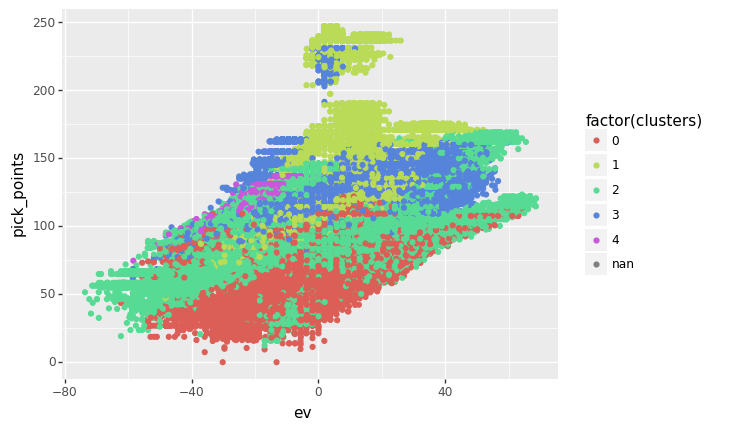

<ggplot: (8793090181042)>

In [ ]:
ggplot(wr_fin) + geom_point(aes(x='ev',y='pick_points',color='factor(clusters)'))

In [ ]:
wr_fin = wr_fin[wr_fin['clusters'].isna() == False]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ind = wr_fin[['pick_points','diff','ev','round_points']]
clus = wr_fin['clusters'].tolist()
ind2 = StandardScaler().fit_transform(ind)

pca = PCA(n_components=2)
comp = pca.fit_transform(ind2)

prince = pd.DataFrame(data = comp, columns = ['pca1', 'pca2'])
prince['clusters'] = clus


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PCA1', 'PCA2'],index=ind.columns)

loading_matrix

,PCA1,PCA2
pick_points,0.813188,-0.139317
diff,0.146406,0.631041
ev,0.822987,-0.042912
round_points,0.073599,0.763841


This table tell us that we should look for higher PCA1 values (the more important component because it explains more variance), while PCA2 isn't too significant, except for higher values indicating more playoff success.

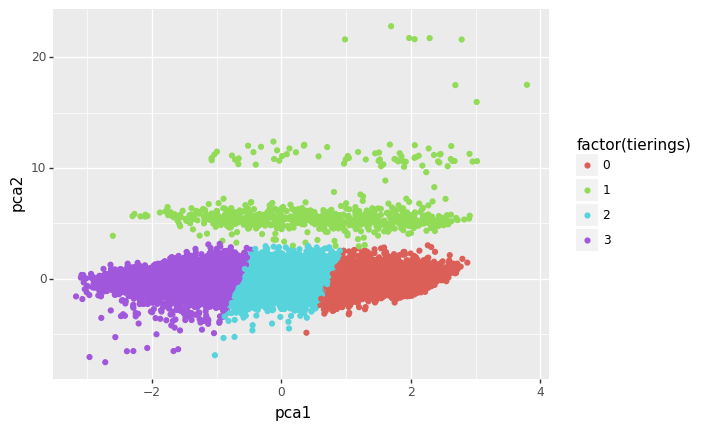

<ggplot: (8793174971130)>

In [ ]:
prince['tierings'] = KMeans(n_clusters = 4).fit_predict(prince.iloc[:,:2])

ggplot(prince) + geom_point(aes(x='pca1', y='pca2',color='factor(tierings)'))

Tiering 0 (red) appears to perform the best scoring-wise and best return on investment, but tiering 1 (green) appears to perform the strongest in the playoffs.  

In [ ]:
data2 = prince[prince['tierings'] == 0]
data2['clusters'].value_counts()

clusters
1.0    6610
3.0    4514
2.0    3435
0.0     451
Name: count, dtype: int64

In [ ]:
data2 = prince[prince['tierings'] == 1]
data2['clusters'].value_counts()

clusters
2.0    233
1.0    200
0.0    191
3.0    151
4.0     10
Name: count, dtype: int64

YAC (cluster 1) and versatile (cluster 3) have the best production in the regular season and playoffs, but the slot/vertical (cluster 2) receivers had higher advance rates in the playoffs and were productive during that period because the final weeks of the season tend to favor variability in production. The unproductive tier and Deebo (clusters 0 and 4) had high advancement rates too since they were consistently behind better players.

## Tightends

In [ ]:
#generating reg and playoff dataframes for tes
big_te = generate_df("TE", "reg")
playoff_te = generate_df("TE", "playoff")

In [ ]:
#storing final cluster results into big_te2 dataframe
big_te2 = generate_clusters(big_te,season22,"TE")
big_te2 = big_te2[big_te2['clusters'].isna() == False]

,total tds,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr_x,games,tgt_sh,...,ppr_sh,avg_cushion,avg_separation,avg_intended_air_yards,catch_percentage,week,carries,offense_pct,weighted_efficiency,clusters
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
clusters,,,,,,,,,,,,,,,,,,,,,
0,2.800000,132.600000,20.300000,5.658375,12.378678,1.844376,2.010553,4.173951,12.800000,0.142442,...,0.093151,6.404587,3.043068,9.310161,61.292088,12.200000,0.100000,0.647898,0.070295,0.0
1,3.692308,239.769231,26.846154,13.665566,21.363141,2.363673,2.245237,5.117175,15.461538,0.146096,...,0.102171,6.323276,3.639168,7.085529,69.347849,14.461538,0.692308,0.714144,0.074471,1.0
2,5.000000,392.571429,35.714286,21.941428,23.258498,2.829201,2.313275,5.863094,15.142857,0.179043,...,0.124130,5.983985,3.307600,6.117946,71.122153,15.000000,0.714286,0.822980,0.081101,2.0
3,12.000000,648.000000,78.000000,64.983887,22.242319,4.248592,4.135083,9.267445,17.000000,0.233487,...,0.170145,6.315604,3.032643,7.299324,75.304859,17.000000,2.000000,0.795882,0.122538,3.0


Index(['total tds', 'receiving_yards_after_catch', 'receiving_first_downs',
       'receiving_epa', 'racr', 'target_share', 'air_yards_share', 'wopr_x',
       'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtdfd_sh',
       'dom', 'w8dom', 'ppr_sh', 'avg_cushion', 'avg_separation',
       'avg_intended_air_yards', 'catch_percentage', 'week', 'carries',
       'offense_pct', 'weighted_efficiency', 'clusters'],
      dtype='object')


**Clusters**

**Cluster 0:** Bottom-tier. Last overall in terms of production for all factors. Pitts and Waller should be higher because they were in low-opportunity offenses and dealt with injuries.

Ex: Greg Dulcich, Logan Thomas

**Cluster 1:** Moderate. Good production in small spurts or average production for all factors. Dalton Schultz could be above this tier since he was injured and Pat Freiermuth can too since he was a startable TE1 last season. Chigoziem Okonkwo is also an exciting target since he's uber productive with the ball.

Ex: Foster Moreau, Noah Fant

**Cluster 2**: Good. TE1s with elite production in various spurts or good production for the whole season.

Ex: Gerald Everett, Dallas Goedert

**Cluster 3**: Travis Kelce. The best.

**Players with respective clusters 2 cells down**

In [ ]:
#generating dictionaries to map player_name to clusters & draft_id to tournamnet_entry_id (playoff & reg merging)
te_clus_dct = pd.Series(big_te2.clusters.values,index=big_te2.player_name).to_dict()
entry_dict = pd.Series(big_te.tournament_entry_id.values, index=big_te.draft_id).to_dict()

#mapping tournament entry using draft_id for playoff_data
big_te2['tournament_entry_id'] = big_te2['draft_id'].map(entry_dict)

In [ ]:
sorted(te_clus_dct.items(), key=lambda x: x[1])

[('Austin Hooper', 0.0),
 ('Darren Waller', 0.0),
 ('Kyle Pitts', 0.0),
 ('Logan Thomas', 0.0),
 ('Mike Gesicki', 0.0),
 ('Zach Ertz', 0.0),
 ('Cade Otton', 0.0),
 ('Greg Dulcich', 0.0),
 ('Juwan Johnson', 0.0),
 ('Kylen Granson', 0.0),
 ('Cole Kmet', 1.0),
 ('Dalton Schultz', 1.0),
 ('Dawson Knox', 1.0),
 ('Hayden Hurst', 1.0),
 ('Hunter Henry', 1.0),
 ('Mark Andrews', 1.0),
 ('Noah Fant', 1.0),
 ('Pat Freiermuth', 1.0),
 ('Robert Tonyan', 1.0),
 ('Tyler Conklin', 1.0),
 ('Foster Moreau', 1.0),
 ('Chigoziem Okonkwo', 1.0),
 ('Jordan Akins', 1.0),
 ('Dallas Goedert', 2.0),
 ('David Njoku', 2.0),
 ('Evan Engram', 2.0),
 ('George Kittle', 2.0),
 ('Gerald Everett', 2.0),
 ('T.J. Hockenson', 2.0),
 ('Tyler Higbee', 2.0),
 ('Travis Kelce', 3.0)]

## **Analyze Clusters & Generate Optimal Selections**
The aformentioned procedure is followed for TEs

In [ ]:
import random
length = random.sample(list(big_te2['draft_id'].unique()), 1000)

lsts = list()
specific = big_te2[big_te2['draft_id'].isin(length)]

for item in specific['draft_id'].unique():
    temp = big_te2[big_te2['draft_id'] == item]
    temp['prod%'] = scipy.stats.percentileofscore(temp['pick_points'],temp['pick_points'])
    temp['pick%'] = 100 - scipy.stats.percentileofscore(temp['overall_pick_number'],temp['overall_pick_number'])
    temp['ev'] = temp['prod%'] - temp['pick%']
    for x in temp['ev']:
        lsts.append(x)

specific['ev'] = lsts
specific['diff'] = specific['overall_pick_number'] - specific['projection_adp']

In [ ]:
te_rand = playoff_te[playoff_te['tournament_entry_id'].isin(specific['tournament_entry_id'])]

te_rand['clusters'] = te_rand['player_name'].map(te_clus_dct)
te_randgb = te_rand.groupby(['tournament_entry_id','player_name']).agg({'overall_pick_number':'count'}).reset_index()
te_randgb.rename(columns = {'overall_pick_number': 'playoff_rounds'}, inplace = True)
te_fin = te_randgb.merge(specific, how = 'outer', on = ['player_name','tournament_entry_id'])
te_fin.fillna({'playoff_rounds':0},inplace = True)
te_fin['round_points'] = te_fin['playoff_rounds'].map(calculate_round_points)


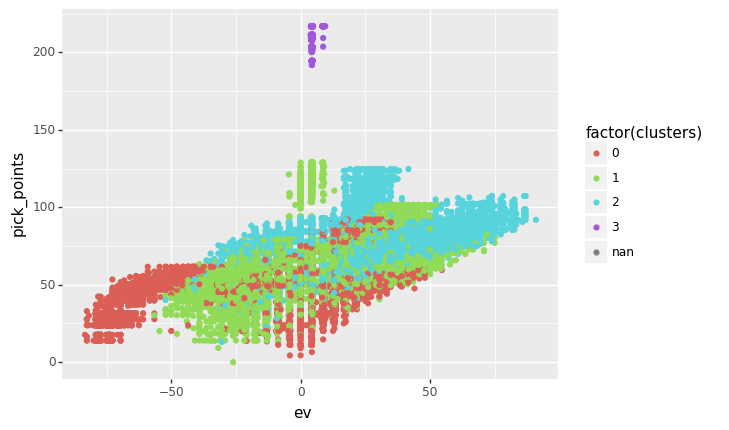

<ggplot: (8792972640109)>

In [ ]:
ggplot(te_fin) + geom_point(aes(x='ev',y='pick_points',color='factor(clusters)'))

Cluster 3 (Travis Kelce) significantly outperforms the rest. Additionally, clusters 1 and 2 also seem to provide positive ev, while scoring on pace with other groups.

In [ ]:
te_fin = te_fin[te_fin['clusters'].isna() == False]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ind = te_fin[['pick_points','diff','ev','round_points']]
clus = te_fin['clusters'].tolist()
ind2 = StandardScaler().fit_transform(ind)

pca = PCA(n_components=2)
comp = pca.fit_transform(ind2)

prince = pd.DataFrame(data = comp, columns = ['pca1', 'pca2'])
prince['clusters'] = clus

#ggplot(prince) + geom_point(aes(x='pca1', y='pca2',color='factor(clusters)'))

In [ ]:
te_fin[te_fin['clusters'] == 1]['player_name'].unique()

array(['Dalton Schultz', 'Robert Tonyan', 'Hayden Hurst', 'Hunter Henry',
       'Noah Fant', 'Cole Kmet', 'Pat Freiermuth', 'Dawson Knox',
       'Mark Andrews', 'Tyler Conklin', 'Foster Moreau',
       'Chigoziem Okonkwo'], dtype=object)

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PCA1', 'PCA2'],index=ind.columns)

loading_matrix

,PCA1,PCA2
pick_points,0.780608,-0.211688
diff,0.272052,0.589292
ev,0.817543,-0.031324
round_points,0.038821,0.786575


This table tell us that we should look for higher PCA1 values (the more important component because it explains more variance), while PCA2 isn't too significant, except for higher values indicating more playoff success.

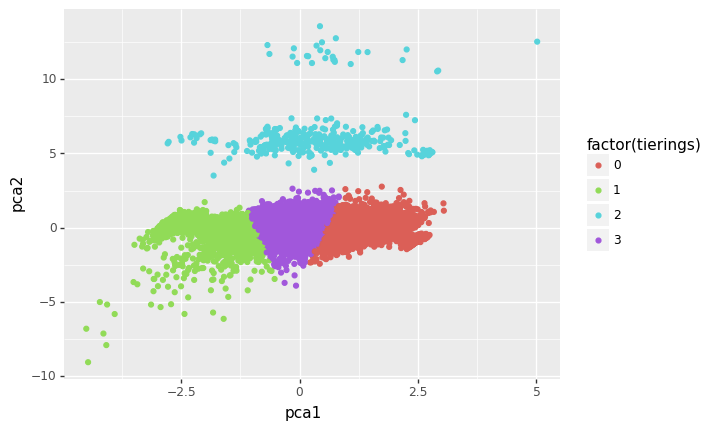

<ggplot: (8793218923045)>

In [ ]:
prince['tierings'] = KMeans(n_clusters = 4).fit_predict(prince.iloc[:,:2])

ggplot(prince) + geom_point(aes(x='pca1', y='pca2',color='factor(tierings)'))

Tiering 2 (blue) and Tiering 0 (red) look like the best groups, generally having more ideal PCA1 values.

In [ ]:
data2 = prince[prince['tierings'] == 2]
data2['clusters'].value_counts()

clusters
1.0    145
2.0    109
0.0     72
3.0     20
Name: count, dtype: int64

Cluster 1 (Moderate) appears to be performing strongest in playoffs, indicating that many of these players could be valuable selections. Travis Kelce (cluster 3), nonetheless, remains unchallenged at the top spot.

## **Conclusion**

In analyzing performance across various player prototypes, we found insightful offerings into potential draft selections. Specificially, our main takeaways from our analysis suggest that

1) Taking QBS with an effective niche (pass-first or scrambling) leads to higher success rates. We recommend taking high ev players with good upside such as **Cousins, Jones, & Lawrence** (Clusters 1 & 3) due to their sizeable roles, presence of complimentary weapons, and lower ADPs.

2) Taking RBs early that dominate snap-counts and have high usage rates leads to higher success rates. We recommend taking workhorse and elite two-way players, while players from Clusters 0 & 4 like **Walker III, Pacheco, & Robinson** should be targeted later as these players were potential league winners and have strong ev's with production next season.


3) Taking WRs early that have elite separation and great target share leads to higher success rates. We recommend taking YAC tier and versatile players, while players from Clusters 2 (Slot) like **Watson, Evans, & Osborn** should be targeted later as they showed signs of outpacing ADPs and better playoff advancement rates.

4) Taking TEs that have shown high-efficiency in spurts and have greater opportunities. We recommend taking TEs such as **Okonkwo, Schultz, & Higbee**, all possibly sliding past their ADPs and having lead to fantasy success.

This observational study sets a strong foundation in creating meaningful groupings that highlight potential players that can be overlooked in future drafts.